# Data Driven
Up until this point, data collection has not been an issue. The methods I've been using having been more focused on domain knowledge rather than collecting a large amount of data. Now that these methods have shown they are not effective, we need access to far more data. To aid with this collection, I've set up a cron job that collects 55 minutes of samples every hour of the day. This process is set to continue until the end of december. Currently I have 4 phones that are actively probing near the capture cards. I'm planning on increasing this number soon, since the more unique devices we have, the more insight we have access to. 

# Ideas For Identifying Devices

Here are some things we've observed from ealier trials:
1. Interarrival times have a large amount of variance, both when staying on and switching channels
2. There appears to be unique distributions for the interarrival times for both of the devices we've worked with
3. The number of packets sent per scan varies per device
4. All Android devices follow the same macro scan plan

Of these 4, the one I am most interested in is number 2. Looking at the 3rd notebook (v3) , you'll see that the histogram of interarrival times for 2 devices across time. Despite the time difference, it appeared that with properly sized bins, that the distributions remained the same. In the image below, phone 1 is phone 3 at an earlier time. Phone 2 is phone 4 at an earlier time.

![Distribution](../images/dist_hit.png)

If we are able to bin interarrival times for multiple devices, we should see this pattern continue. First, let's get all the data we are working with.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from IPython.display import display
import time
from scipy import stats
import hashlib
from datetime import datetime

In [72]:
def get_single_file(filename):
    df1 = pd.read_csv(filename, sep=' ')
    df1 = df1.set_axis(["ATime","RTime", "Start", "End", "Signal", "Seq", "Source"], axis=1)
    freq_map = {2412: 1, 2437: 6, 2462: 11}
    df1 = df1.replace({"Start": freq_map})
    df1 = df1.replace({"End": freq_map})
    df1["Tag"] = df1["Start"].astype(str) + "->" + df1["End"].astype(str)
    df1["ITime"] = df1["ATime"].diff()
    df1 = df1.astype({"ATime": np.float32, "RTime": np.float32, "Signal": np.float32})
    return df1.loc[1:, :]



# each of the parameters should be a list of values
# might be a more efficient way with os.walk?
def get_data(days, months, years):
    start = time.time()
    final_res = []
    for year in years:
        for month in months:
            for day in days:
                single_day = []
                for sample in range(24):
                    try:
                        df = get_single_file(f"../data/text/hourly/{day}_{month}_{year}/sample{sample:02}.txt")
                        df["Sample"] = sample
                        single_day.append(df)
                        
                    except Exception as e:
                        print(f"Error with {day}/{month}/{year}: {e}")
                        continue
                    
                    
                x = pd.concat(single_day)
                
                
                x["Date"] = datetime.strptime(f"{day}/{month}/{year}", '%d/%m/%y')
                x["CType"] = "Different" 
                x.loc[x["Start"] == x["End"], "CType"] = "Same"
                
                x = x[["ATime", "RTime", "ITime", "Date", "Start", "End", "Tag", "CType", "Signal", "Seq", "Source"]]
                final_res.append(x)
                
    end = time.time()
    print("Total Time: ", end - start)
    return pd.concat(final_res)

df = get_data(range(17,21,1), [11], [22])

Total Time:  4.4066925048828125


In [73]:
display(df)

,ATime,RTime,ITime,Date,Start,End,Tag,CType,Signal,Seq,Source
1,1.668668e+09,0.060131,0.008357,2022-11-17,11,6,11->6,Different,-91.0,58,00:22:58:70:00:dc
2,1.668668e+09,0.077098,0.016967,2022-11-17,6,11,6->11,Different,-73.0,157,0e:60:86:36:52:dc
3,1.668668e+09,0.080954,0.003856,2022-11-17,11,6,11->6,Different,-92.0,59,00:22:58:70:00:dc
4,1.668668e+09,0.145777,0.064823,2022-11-17,1,11,1->11,Different,-76.0,160,0e:60:86:36:52:dc
5,1.668668e+09,0.166074,0.020297,2022-11-17,1,1,1->1,Same,-78.0,161,0e:60:86:36:52:dc
...,...,...,...,...,...,...,...,...,...,...,...
19458,1.669014e+09,3297.072266,0.041177,2022-11-20,11,11,11->11,Same,-30.0,1514,b2:87:66:09:27:91
19459,1.669014e+09,3297.074463,0.002143,2022-11-20,11,11,11->11,Same,-29.0,1515,b2:87:66:09:27:91
19460,1.669014e+09,3297.136475,0.062000,2022-11-20,1,11,1->11,Different,-89.0,1516,b2:87:66:09:27:91
19461,1.669014e+09,3298.612305,1.475909,2022-11-20,1,1,1->1,Same,-90.0,1538,70:b3:17:96:65:47


The first thing we should do is keep only the probes from the devices we are interested in. To do this we need to see which of the source addresses show up the most frequently.

In [74]:
sources = list(df[df.Signal > -45].groupby("Source").size().sort_values(ascending=False).head(3).index)
df = df[df.Source.isin(sources)]
df["Phone"] = df["Source"].astype("category").cat.codes

In [75]:
display(df)

,ATime,RTime,ITime,Date,Start,End,Tag,CType,Signal,Seq,Source,Phone
11,1.668668e+09,3.931422,1.060161,2022-11-17,1,11,1->11,Different,-28.0,1024,b2:87:66:09:27:91,1
13,1.668668e+09,3.931458,0.000016,2022-11-17,11,6,11->6,Different,-74.0,1024,b2:87:66:09:27:91,1
15,1.668668e+09,3.933816,0.000020,2022-11-17,11,6,11->6,Different,-73.0,1025,b2:87:66:09:27:91,1
16,1.668668e+09,3.933832,0.000016,2022-11-17,1,11,1->11,Different,-26.0,1025,b2:87:66:09:27:91,1
17,1.668668e+09,3.974590,0.040758,2022-11-17,1,1,1->1,Same,-29.0,1026,b2:87:66:09:27:91,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19456,1.669014e+09,3297.031250,0.002410,2022-11-20,6,11,6->11,Different,-69.0,1513,b2:87:66:09:27:91,1
19457,1.669014e+09,3297.031250,0.000019,2022-11-20,11,6,11->6,Different,-29.0,1513,b2:87:66:09:27:91,1
19458,1.669014e+09,3297.072266,0.041177,2022-11-20,11,11,11->11,Same,-30.0,1514,b2:87:66:09:27:91,1
19459,1.669014e+09,3297.074463,0.002143,2022-11-20,11,11,11->11,Same,-29.0,1515,b2:87:66:09:27:91,1


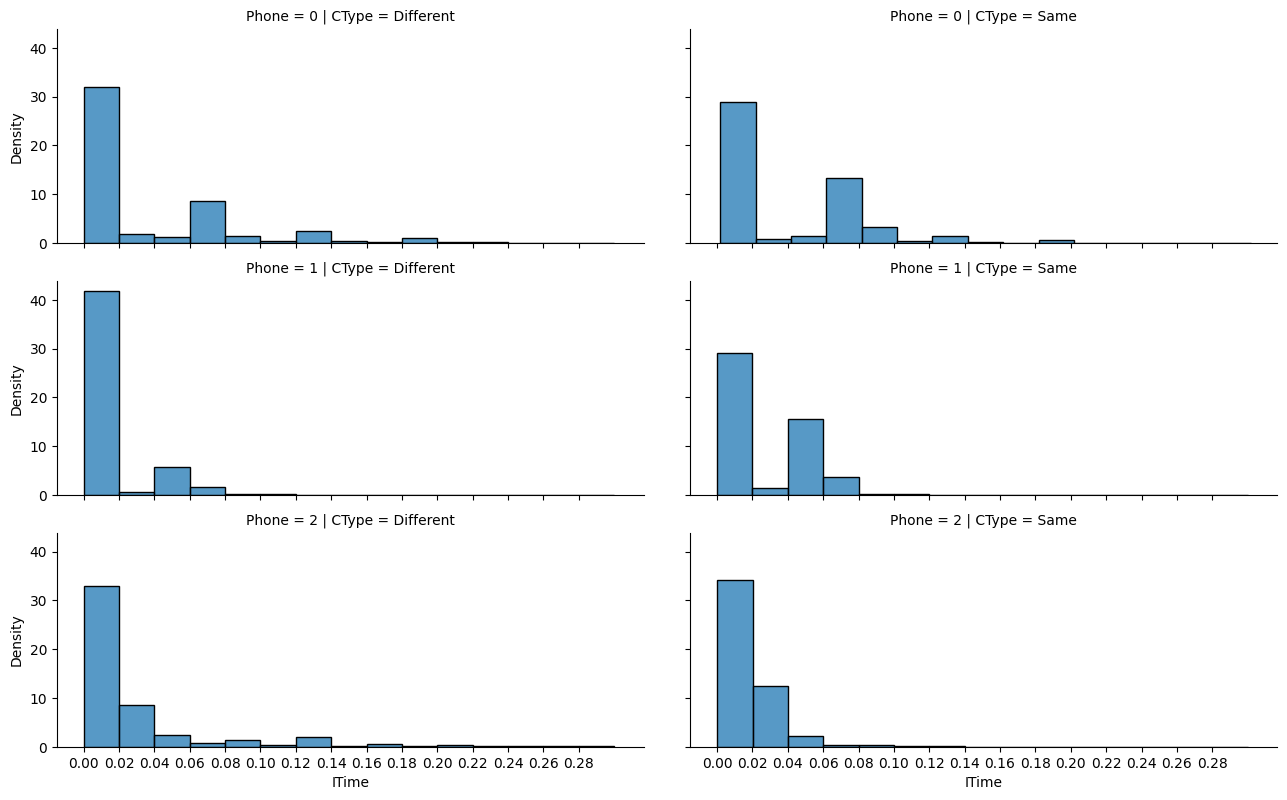

In [77]:
short = df.loc[df["ITime"] < 0.3, ["ITime", "CType", "Phone"]]
g = sns.FacetGrid(short, col="CType", sharey=True, sharex=True, row="Phone")
g.map(sns.histplot, "ITime", binwidth = 0.02, stat="density")
g.figure.set_size_inches(14, 8)

for ax in g.axes.flat:
    ax.set_xticks(np.arange(0, 0.3, 0.02)) # <--- set the ticks first
plt.show()

And the CDFs:

In [ ]:
sns.displot(df[df.ITime < 0.4], x="ITime", col="CType", hue="Phone", kind="ecdf", palette="deep")
plt.show()